In [1]:
!pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=2f1d886e63071e34519cfd2e2bb318d958048e0f93f391fb75094cbaab9760b6
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [2]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandasql as ps
import pandas as pd
import seaborn as sns

# Embudos de Marketing

Un embudo de marketing nos habla sobre cuántos clientes están pasando por cada uno de los pasos que los llevará a una venta.

Imaginemos que somos dueños de una empresa que vende teléfonos celulares por medio de una página de Internet. Hemos puesto un rastreador (tracker) para capturar información de lo que nuestros usuarios hacen dentro de la página.

Específicamente, queremos entender qué proporción de usuarios pasar por cada uno de los siguientes pasos:

1. Visita a la página principal (Home Page Loaded) -->>
2. Agregar a carrito (Add to Cart) -->>
3. Compra (Purchase)

Un embudo de este tipo, lo podemos visualizar de la siguiente manera:

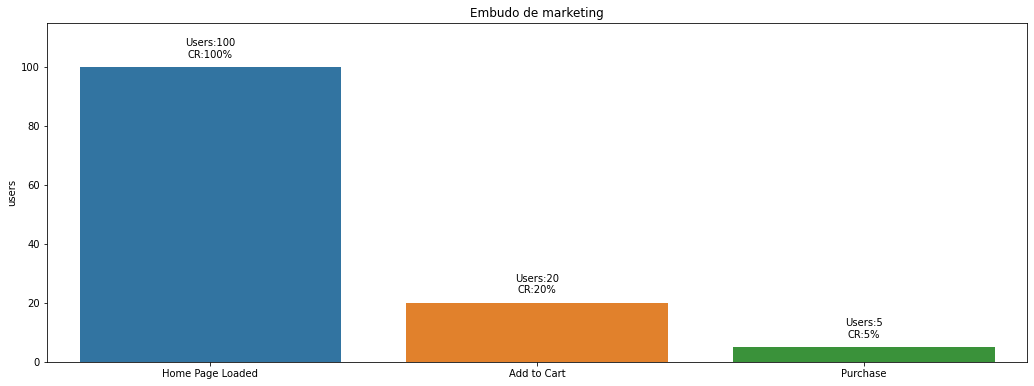

In [3]:
df = pd.DataFrame(data={
    "step": ["Home Page Loaded", "Add to Cart", "Purchase"],
    "users": [100, 20, 5],
    "conversion_rate": [1, 0.2, 0.05]
})

fig, ax = plt.subplots(figsize=(15, 6))

sns.barplot(data=df, x="step", y="users")
ax.set_ylim(0, 115)
ax.set_xlabel("")
ax.set_title("Embudo de marketing")

for p, cr in zip(ax.patches, df.conversion_rate):
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h+10)
    text = f"Users:{int(h)}\nCR:{cr:.0%}"
    ax.annotate(s=text, xy=xy, ha="center", va="top")

fig.tight_layout(pad=3.0)

Usemos SQL para calcular un embudo de ventas.

## Simulación de datos

Para simular estos datos asumamos lo siguientes:

- `1000` usuarios entraron a nuestra página (detonaron mil veces el evento `Home Page Loaded`)
- Hay una probabilidad del `25%` de que un usuario agregue algo al carrito.
- De los usuarios que agregaron a carrito, hay un `40%` de probabilidad de que terminen comprando.

En nuestra tabla guardamos la información para distinguir a cada usuario (`user_id`), el evento que detonaron (`event_name`) y una referencia de tiempo de cuando detonaron el evento (`timestamp`).

In [4]:
np.random.seed(200)
n_users = 500
cr_first_event = 0.25
cr_second_event = 0.40

user_ids = []
event_names = []
timestamps = []

startDate = datetime.datetime(2021, 5, 1,00,00)

for i in range(n_users):

  n_events = int(np.random.uniform(low=1, high=20))

  # First event simulation
  user_ids = user_ids + [i]*n_events
  event_names = event_names + ["Home Page Loaded"]*n_events

  timestamps_1 = []

  for j in range(n_events):
    random_range_1 = np.random.uniform(low=0, high=30)
    timestamp_first_event = startDate + datetime.timedelta(days=random_range_1)

    timestamps_1.append(timestamp_first_event)
    timestamps.append(timestamp_first_event.strftime("%d/%m/%y %H:%M"))

  # Second event simulation
  if np.random.uniform() <= cr_first_event:
    user_ids = user_ids + [i]*n_events
    event_names = event_names + ["Add to Cart"]*n_events

    timestamps_2 = []

    for k in range(n_events):
      random_range_2 = np.random.uniform(low=-3, high=10)
      timestamp_second_event = timestamps_1[j] + datetime.timedelta(days=random_range_2)

      timestamps_2.append(timestamp_second_event)
      timestamps.append(timestamp_second_event.strftime("%d/%m/%y %H:%M"))

    # Third event simulation
    if np.random.uniform() <= cr_second_event:
      user_ids = user_ids + [i]*n_events
      event_names = event_names + ["Purchase"]*n_events

      for l in range(n_events):
        random_range_3 = np.random.uniform(low=-3, high=10)
        timestamp_third_event = timestamps_2[l] + datetime.timedelta(days=random_range_3)

        timestamps.append(timestamp_third_event.strftime("%d/%m/%y %H:%M"))


events = pd.DataFrame(data={
    "user_id": user_ids,
    "event_name": event_names,
    "timestamp": timestamps,
})
events["timestamp"] = pd.to_datetime(events["timestamp"], format="%d/%m/%y %H:%M")

In [12]:
ps.sqldf("""
SELECT *
FROM events
LIMIT 5
""")

,user_id,event_name,timestamp
0,0,Home Page Loaded,2021-05-07 19:06:00.000000
1,0,Home Page Loaded,2021-05-18 19:58:00.000000
2,0,Home Page Loaded,2021-05-13 20:22:00.000000
3,0,Home Page Loaded,2021-05-23 22:10:00.000000
4,0,Home Page Loaded,2021-05-01 02:03:00.000000


# Ejercicios

Construyamos un embudo con los datos que hemos generado.

## Embudo sencillo

Un embudo sencillo cuenta la cantidad de usuarios únicos que realizan cierto evento. Para este ejercicio, calcula la cantidad de usuarios únicos que han realizado cada uno de los eventos. También calcula la proporción de usuarios que realizan cada evento sobre el total de usuarios que realizaron el primer evento.

Las columnas se deberían de llamar `step`, `users` y `conversion_rate`.

step                 users       conversion_rate
Home Page Loaded     100         100%
Add to Cart          20          20%
Purchase             5           5%

In [32]:
sql_query = ("""
SELECT 
event_name AS step,
COUNT(DISTINCT user_id) AS users,
1.0*COUNT(DISTINCT user_id)/(SELECT COUNT(DISTINCT user_id) FROM events) as conversion_rate
FROM events
GROUP BY
step
ORDER BY conversion_rate DESC
""")

funnel_df = ps.sqldf(sql_query)

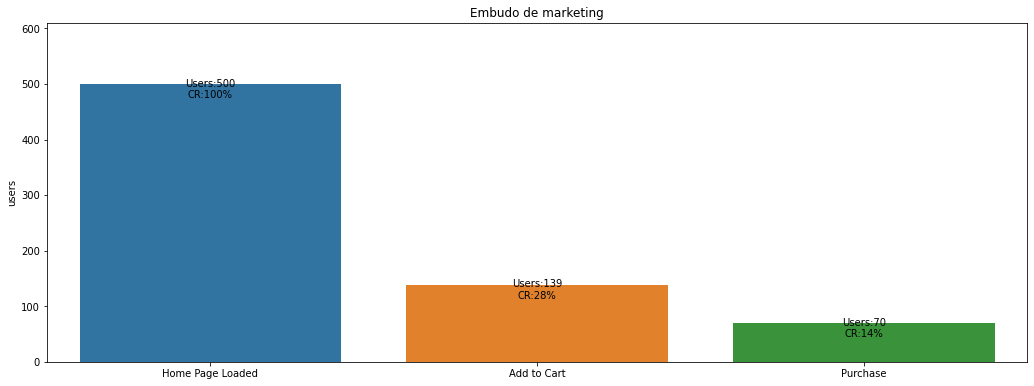

In [33]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.barplot(data=funnel_df, x="step", y="users")
ax.set_ylim(0, 610)
ax.set_xlabel("")
ax.set_title("Embudo de marketing")

for p, cr in zip(ax.patches, funnel_df.conversion_rate):
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h+10)
    text = f"Users:{int(h)}\nCR:{cr:.0%}"
    ax.annotate(s=text, xy=xy, ha="center", va="top")

fig.tight_layout(pad=3.0)

In [34]:
funnel_df

,step,users,conversion_rate
0,Home Page Loaded,500,1.000
1,Add to Cart,139,0.278
2,Purchase,70,0.140


### Embudo en una función

Un ejercicio adicional es construir una función en donde solo se defina el embudo y arroje la tabla con los resultados. Adicionalmente, la función podría graficar el embudo.

In [ ]:
## escribe tu código aquí

Una limitante de esta manera de calcular embudos es que nos pueden salir tasas de conversión mayores al 100%, lo cual no sería correcto.

Esto podría suceder si los usuarios pueden agregar productos a su carrito sin necesariamente pasar por la página principal. Las campañas de marketing pueden llevar directamente a páginas de productos y no necesariamente pasar por la página principal.

Veamos este caso en acción:

- Imaginemos que hay 5000 usuarios que no pasaron por la página principal, sino entraron por una página de productos.

In [ ]:
np.random.seed(200)
n_users = 500
cr_first_event = 0.25
cr_second_event = 0.40

user_ids = []
event_names = []
timestamps = []

startDate = datetime.datetime(2021, 5, 1,00,00)

for i in range(n_users):

  n_events = int(np.random.uniform(low=1, high=20))

  # First event simulation
  user_ids = user_ids + [i]*n_events
  event_names = event_names + ["Product Page Loaded"]*n_events

  timestamps_1 = []

  for j in range(n_events):
    random_range_1 = np.random.uniform(low=0, high=30)
    timestamp_first_event = startDate + datetime.timedelta(days=random_range_1)

    timestamps_1.append(timestamp_first_event)
    timestamps.append(timestamp_first_event.strftime("%d/%m/%y %H:%M"))

  # Second event simulation
  if np.random.uniform() <= cr_first_event:
    user_ids = user_ids + [i]*n_events
    event_names = event_names + ["Add to Cart"]*n_events

    timestamps_2 = []

    for k in range(n_events):
      random_range_2 = np.random.uniform(low=-3, high=10)
      timestamp_second_event = timestamps_1[j] + datetime.timedelta(days=random_range_2)

      timestamps_2.append(timestamp_second_event)
      timestamps.append(timestamp_second_event.strftime("%d/%m/%y %H:%M"))

    # Third event simulation
    if np.random.uniform() <= cr_second_event:
      user_ids = user_ids + [i]*n_events
      event_names = event_names + ["Purchase"]*n_events

      for l in range(n_events):
        random_range_3 = np.random.uniform(low=-3, high=10)
        timestamp_third_event = timestamps_2[l] + datetime.timedelta(days=random_range_3)

        timestamps.append(timestamp_third_event.strftime("%d/%m/%y %H:%M"))


events_product_page = pd.DataFrame(data={
    "user_id": user_ids,
    "event_name": event_names,
    "timestamp": timestamps,
})
events_product_page["timestamp"] = pd.to_datetime(events_product_page["timestamp"], format="%d/%m/%y %H:%M")

all_events = pd.concat([events, events_product_page])

In [ ]:
# Escriban su query aquí
sql_query = """
"""

funnel_df = ps.sqldf(sql_query)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.barplot(data=funnel_df, x="step", y="users")
ax.set_ylim(0, 650)
ax.set_xlabel("")
ax.set_title("Embudo de marketing (con usuarios que llegan a Product Page)")

for p, cr in zip(ax.patches, funnel_df.conversion_rate):
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h+10)
    text = f"Users:{int(h)}\nCR:{cr:.0%}"
    ax.annotate(s=text, xy=xy, ha="center", va="top")

fig.tight_layout(pad=3.0)

## Embudo detallado

Ahora, en lugar de solo contar los usuarios únicos que hacen un evento, tomemos la información para determinar qué usuario siguieron exactamente los pasos de nuestro embudo y en ese orden.

Pista: necesitaremos hacer uso de `JOIN` para determinar qué usuarios hicieron los eventos en el orden que ueremos.

In [ ]:
# escribe tu código aquí

## Embudo con filtros

En el ejercicio anterior, determinamos cómo construir un embudo en el que cada usuario tiene que realizar en orden las acciones específicas que definen nuestro embudo. Sin embargo, no pusimos una reestricción de tiempo entre eventos, esto es, un usuario se pudo haber tardado 1 semana en realizar el segundo evento y de todas maneras lo vamos a considerar como "convertido".

Ahora, pongamos un filtro para solo considerar eventos que no toman más de 1 día en realizarse, esto es, si un usuario entra a la página principal, solo va a contar como "convertido" si no tarda más de 1 día en agregar un producto a su carrito y, a su vez, no tarda más de 1 día en terminar la compra desde que agregó al carrito para contar como convertido.

In [ ]:
# escribe tu código aquí

## Más visualizaciones de embudos

In [ ]:
from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y = ["Home Page Loaded", "Add to Cart", "Purchase"],
    x = [100, 20, 5],
    textposition = "inside",
    textinfo = "value+percent initial")
)

fig.show()